<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:15: SyntaxWarning: invalid escape sequence '\j'
<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:15: SyntaxWarning: invalid escape sequence '\j'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38724\326192441.py:13: SyntaxWarning: invalid escape sequence '\A'
  all_idb1_blast_dir = 'datasets\ALL_IDB1\\all_blast'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38724\326192441.py:14: SyntaxWarning: invalid escape sequence '\A'
  all_idb1_normal_dir = 'datasets\ALL_IDB1\\normal'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38724\326192441.py:15: SyntaxWarning: invalid escape sequence '\j'
  all_idb2_dir = 'datasets\jpg img'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential 

Epoch 1/20


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 713ms/step - accuracy: 0.7200 - loss: 0.7593 - val_accuracy: 0.8108 - val_loss: 0.5221
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 710ms/step - accuracy: 0.8552 - loss: 0.4007 - val_accuracy: 0.8108 - val_loss: 0.2594
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 714ms/step - accuracy: 0.8408 - loss: 0.2224 - val_accuracy: 0.8514 - val_loss: 0.1619
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 795ms/step - accuracy: 0.9227 - loss: 0.1342 - val_accuracy: 0.9595 - val_loss: 0.1107
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 766ms/step - accuracy: 0.9687 - loss: 0.0874 - val_accuracy: 0.8649 - val_loss: 0.4764
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 836ms/step - accuracy: 0.9476 - loss: 0.1050 - val_accuracy: 0.9595 - val_loss: 0.0922
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 972ms/step - accuracy: 0.9960 - loss: 0.0603 - val_accuracy: 0.9459 - val_loss: 0.1571
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 890ms/step - accuracy: 0.9882 - loss: 0.0370 - val_accuracy: 0.9595 -

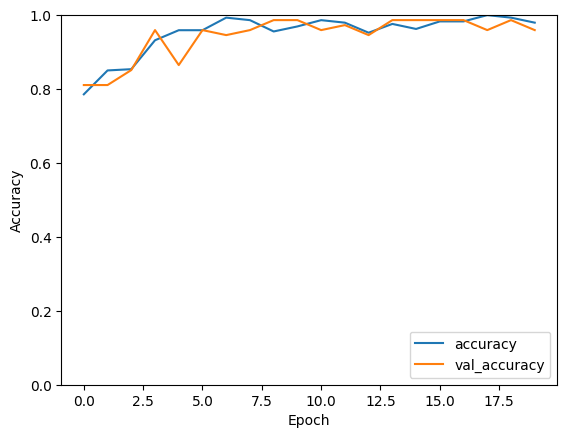

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\jpg img'

# Image parameters
img_height, img_width = 224, 224  # Resize all images to a standard size
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images from both ALL-IDB1 and ALL-IDB2
def load_images_from_dir(directory, label, augment=False):
    data = []
    labels = []
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        
        # Adaptive sharpening
        image = adaptive_sharpen(image)
        
        # Normalize pixel values
        image = image / 255.0
        
        # Append label (0 for normal, 1 for blast)
        labels.append(label)
        data.append(image)
    
    return np.array(data), np.array(labels)

# Load ALL-IDB1 and ALL-IDB2 images
all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, label=1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, label=0)
all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, label=1)  # ALL-IDB2 are cropped individual cells

# Combine data from both datasets
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data, all_idb2_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels, all_idb2_labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=20)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Epoch 1/20


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 253s 25s/step - accuracy: 0.5665 - loss: 4.4729 - val_accuracy: 0.8108 - val_loss: 0.5018
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 263s 26s/step - accuracy: 0.7827 - loss: 0.5091 - val_accuracy: 0.8108 - val_loss: 0.4788
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 244s 24s/step - accuracy: 0.8301 - loss: 0.4073 - val_accuracy: 0.8108 - val_loss: 0.3052
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 255s 25s/step - accuracy: 0.8290 - loss: 0.3199 - val_accuracy: 0.8108 - val_loss: 0.2993
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 251s 25s/step - accuracy: 0.8522 - loss: 0.1903 - val_accuracy: 0.8108 - val_loss: 0.4242
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 251s 25s/step - accuracy: 0.8267 - loss: 0.3387 - val_accuracy: 0.8108 - val_loss: 0.2580
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 245s 24s/step - accuracy: 0.8739 - loss: 0.1857 - val_accuracy: 0.8243 - val_loss: 0.2637
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 268s 27s/step - accuracy: 0.8817 - loss: 0.2049 - val_accuracy: 0.2162 - val_

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

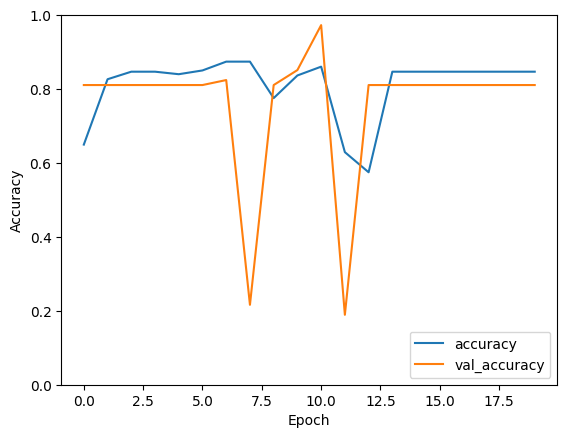

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224  # Resize all images to a standard size
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images from both ALL-IDB1 and ALL-IDB2
def load_images_from_dir(directory, label, augment=False):
    data = []
    labels = []
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        
        # Adaptive sharpening
        image = adaptive_sharpen(image)
        
        # Normalize pixel values
        image = image / 255.0
        
        # Append label (0 for normal, 1 for blast)
        labels.append(label)
        data.append(image)
    
    return np.array(data), np.array(labels)

# Load ALL-IDB1 and ALL-IDB2 images
all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, label=1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, label=0)
all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, label=1)  # ALL-IDB2 are cropped individual cells

# Combine data from both datasets
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data, all_idb2_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels, all_idb2_labels])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
# history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#                     validation_data=(X_test, y_test),
#                     epochs=20)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the CNN model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=20)


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 121s 12s/step - accuracy: 0.7684 - loss: 0.6955 - val_accuracy: 0.4189 - val_loss: 0.7420
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 108s 10s/step - accuracy: 0.8036 - loss: 0.7060 - val_accuracy: 0.1892 - val_loss: 0.9350
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step - accuracy: 0.4655 - loss: 0.7165 - val_accuracy: 0.3243 - val_loss: 0.7551
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 11s/step - accuracy: 0.8546 - loss: 0.6766 - val_accuracy: 0.5541 - val_loss: 0.6836
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 9s/step - accuracy: 0.8459 - loss: 0.7253 - val_accuracy: 0.4595 - val_loss: 0.7141
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 109s 10s/step - accuracy: 0.7353 - loss: 0.6767 - val_accuracy: 0.6622 - val_loss: 0.6328
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 109s 10s/step - accuracy: 0.7705 - loss: 0.6710 - val_accuracy: 0.7973 - val_loss: 0.5644
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.8068 - loss: 0.6572 - val_accuracy: 0.5270 - val_los

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

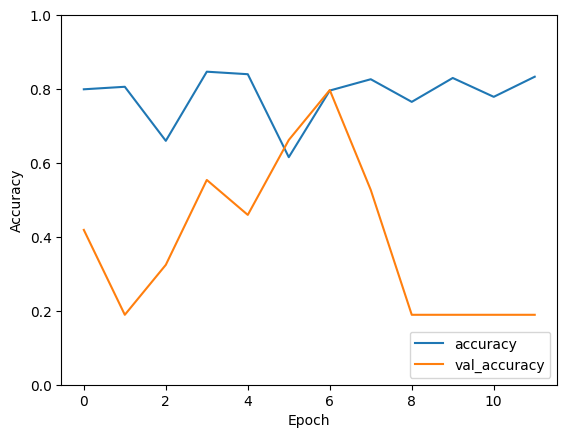

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224  # Resize all images to a standard size
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images from both ALL-IDB1 and ALL-IDB2
def load_images_from_dir(directory, label, augment=False):
    data = []
    labels = []
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        
        # Adaptive sharpening
        image = adaptive_sharpen(image)
        
        # Normalize pixel values
        image = image / 255.0
        
        # Append label (0 for normal, 1 for blast)
        labels.append(label)
        data.append(image)
    
    return np.array(data), np.array(labels)

# Load ALL-IDB1 and ALL-IDB2 images
all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, label=1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, label=0)
all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, label=1)  # ALL-IDB2 are cropped individual cells

# Combine data from both datasets
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data, all_idb2_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels, all_idb2_labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data Augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    channel_shift_range=50.0  # Channel shifting
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Fine-tune the last few layers of VGG16
base_model.trainable = True
for layer in base_model.layers[:-6]:
    layer.trainable = False

# Build the CNN model with batch normalization
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7842 - loss: 0.7590 - val_accuracy: 0.8243 - val_loss: 0.4901
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.7993 - loss: 0.6565 - val_accuracy: 0.8514 - val_loss: 0.4647
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.8743 - loss: 0.4682 - val_accuracy: 0.8514 - val_loss: 0.3738
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.8971 - loss: 0.3441 - val_accuracy: 0.8649 - val_loss: 0.2932
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.9256 - loss: 0.3364 - val_accuracy: 0.8378 - val_loss: 0.2791
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.9048 - loss: 0.2659 - val_accuracy: 0.8649 - val_loss: 0.2449
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.9279 - loss: 0.2297 - val_accuracy: 0.8649 - val_loss: 0.2165
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.9101 - loss: 0.2157 - val_accuracy: 0.8784 - val_loss: 0.1936
Ep

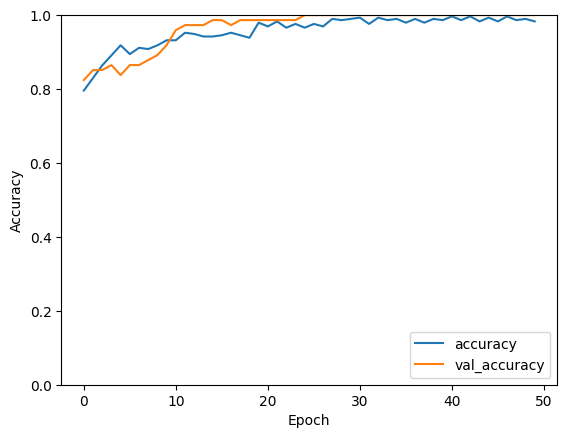

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)
all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, 1)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data, all_idb2_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels, all_idb2_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with Focal Loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [26]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │       131,32

 Total params: 15,903,557 (60.67 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 791,556 (3.02 MB)

In [35]:
model.save('vgg.keras')

In [2]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im086_0.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Predicted label: Normal


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.4827 - loss: 0.7238 - val_accuracy: 0.9189 - val_loss: 0.4618
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 11s/step - accuracy: 0.7497 - loss: 0.6275 - val_accuracy: 0.9730 - val_loss: 0.4098
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - accuracy: 0.8745 - loss: 0.5182 - val_accuracy: 0.9324 - val_loss: 0.3672
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 109s 11s/step - accuracy: 0.8567 - loss: 0.4779 - val_accuracy: 0.9324 - val_loss: 0.2998
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1268s 139s/step - accuracy: 0.8966 - loss: 0.4259 - val_accuracy: 0.9595 - val_loss: 0.2450
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.9298 - loss: 0.3505 - val_accuracy: 0.9324 - val_loss: 0.2348
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.9406 - loss: 0.2770 - val_accuracy: 0.9054 - val_loss: 0.2358
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.9132 - loss: 0.2576 - val_accuracy: 0.9054 - val_loss: 

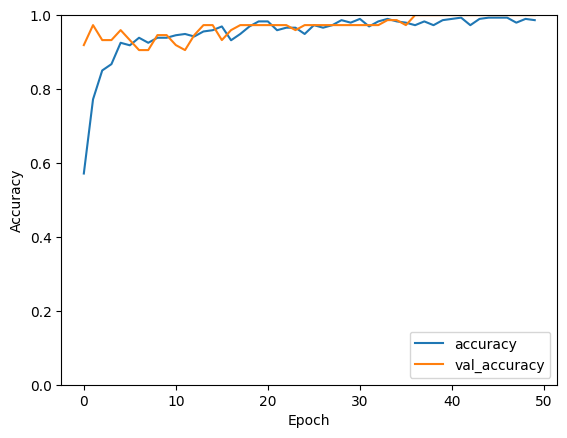

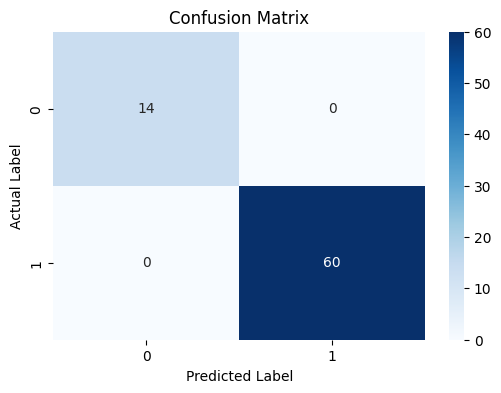

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19  # Changed to VGG19
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix  # Added confusion matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)
all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, 1)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data, all_idb2_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels, all_idb2_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Changed to VGG19
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,440,581 (303.04 MB)

 Trainable params: 26,480,193 (101.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,960,388 (202.03 MB)

In [7]:
model.save("vgg19.keras", save_format="keras")

In [21]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg19.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'datasets\\ALL_IDB1\\normal\\Im085_0.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicted label: Blast


Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.4260 - loss: 0.7558 - val_accuracy: 0.8182 - val_loss: 0.6433
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5233 - loss: 0.7298 - val_accuracy: 0.8636 - val_loss: 0.6144
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.6305 - loss: 0.6550 - val_accuracy: 0.9545 - val_loss: 0.5876
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6013 - loss: 0.6678 - val_accuracy: 0.9545 - val_loss: 0.5605
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.6966 - loss: 0.6159 - val_accuracy: 0.9545 - val_loss: 0.5340
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7149 - loss: 0.5943 - val_accuracy: 0.9545 - val_loss: 0.5099
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.7471 - loss: 0.5734 - val_accuracy: 0.9545 - val_loss: 0.4874
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7548 - loss: 0.5538 - val_accuracy: 0.9545 - val_loss: 0.4663
Epoch 9/50
3/3 ━━━

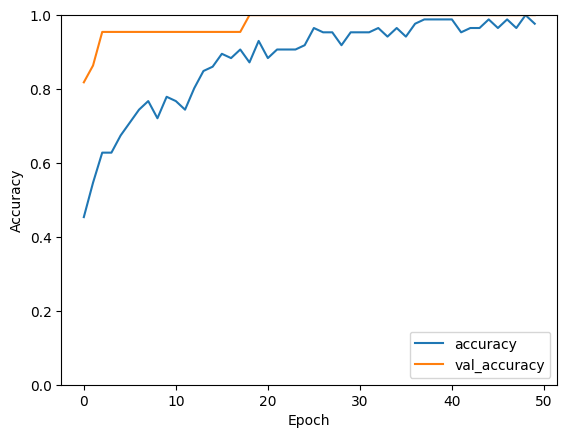

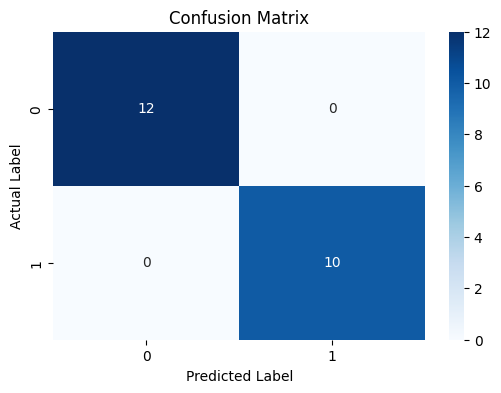

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19  # Changed to VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix  # Added confusion matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)
# all_idb2_data, all_idb2_labels = load_images_from_dir(all_idb2_dir, 1)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('vgg19.keras')

In [16]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 79,440,581 (303.04 MB)

 Trainable params: 26,480,193 (101.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,960,388 (202.03 MB)

In [10]:
model.save('vgg191.h5')

In [18]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg19.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im005_1.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Predicted label: Blast


MobileNetV2

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22552\3989361313.py:78: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4239 - loss: 1.0224 - val_accuracy: 0.7273 - val_loss: 0.5395
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5329 - loss: 0.7613 - val_accuracy: 0.9545 - val_loss: 0.3880
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7238 - loss: 0.5377 - val_accuracy: 1.0000 - val_loss: 0.2945
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step - accuracy: 0.8385 - loss: 0.4403 - val_accuracy: 1.0000 - val_loss: 0.2367
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - accuracy: 0.8870 - loss: 0.3099 - val_accuracy: 1.0000 - val_loss: 0.1828
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - accuracy: 0.9122 - loss: 0.2574 - val_accuracy: 1.0000 - val_loss: 0.1422
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.8754 - loss: 0.3147 - val_accuracy: 1.0000 - val_loss: 0.1084
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 753ms/step - accuracy: 0.9285 - loss: 0.2158 - val_accuracy: 1.0000 - val_loss: 0.0830
Epoch 9/50


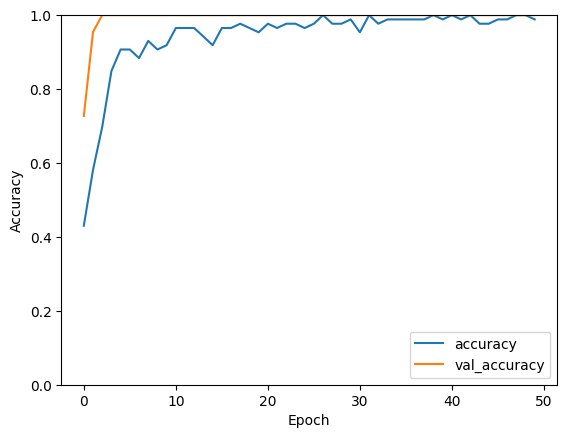

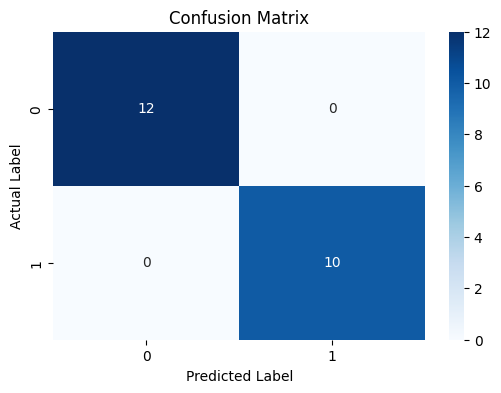

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2  # Changed to MobileNetV2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'
all_idb2_dir = 'datasets\\jpg img'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_mobilenetv2.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Get training accuracy from history after fine-tuning
final_train_acc = history_finetune.history['accuracy'][-1]
print(f'Training accuracy: {final_train_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('mobilenetv2.keras')


In [3]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 54,974,533 (209.71 MB)

 Trainable params: 18,313,473 (69.86 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 36,626,948 (139.72 MB)

In [8]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('mobilenetv2.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'datasets\\ALL_IDB1\\all_blast\\Im006_1.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label: Blast


InceptionV3

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4747 - loss: 0.8389 - val_accuracy: 0.7727 - val_loss: 0.4858
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6206 - loss: 0.7554 - val_accuracy: 0.8182 - val_loss: 0.4096
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7296 - loss: 0.5476 - val_accuracy: 0.9545 - val_loss: 0.3170
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7433 - loss: 0.5112 - val_accuracy: 1.0000 - val_loss: 0.2513
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7511 - loss: 0.5416 - val_accuracy: 1.0000 - val_loss: 0.2217
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7240 - loss: 0.5091 - val_accuracy: 0.9545 - val_loss: 0.2034
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7416 - loss: 0.5042 - val_accuracy: 1.0000 - val_loss: 0.1774
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8600 - loss: 0.3548 - val_accuracy: 1.0000 - val_loss: 0.1608
Epoch 9/50
3/3 ━━━━━━━━━━━

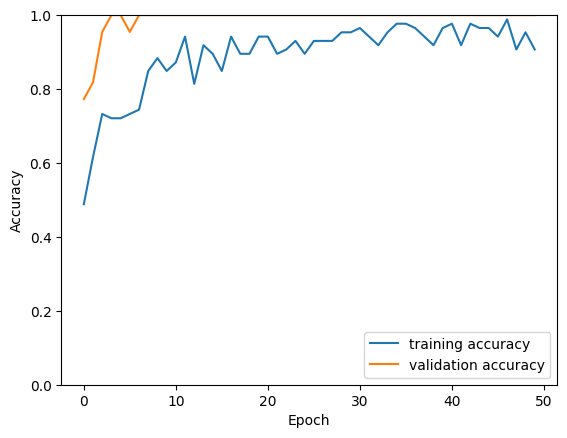

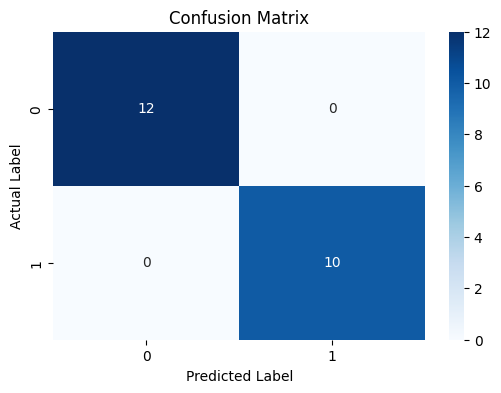

In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import InceptionV3  # Changed to InceptionV3
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_inceptionv3.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Get training accuracy from history after fine-tuning
final_train_acc = history_finetune.history['accuracy'][-1]
print(f'Training accuracy: {final_train_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('inceptionv3.keras')


In [10]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 104,760,933 (399.63 MB)

 Trainable params: 34,908,833 (133.17 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 69,817,668 (266.33 MB)

In [12]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('inceptionv3.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im086_0.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: Normal


DenseNet201

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 68s 15s/step - accuracy: 0.4785 - loss: 0.8173 - val_accuracy: 0.8182 - val_loss: 0.4376
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.6758 - loss: 0.5940 - val_accuracy: 1.0000 - val_loss: 0.3285
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.7277 - loss: 0.5311 - val_accuracy: 1.0000 - val_loss: 0.2628
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.7976 - loss: 0.4462 - val_accuracy: 1.0000 - val_loss: 0.2082
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.8406 - loss: 0.3729 - val_accuracy: 1.0000 - val_loss: 0.1646
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.8619 - loss: 0.3542 - val_accuracy: 1.0000 - val_loss: 0.1404
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9205 - loss: 0.2833 - val_accuracy: 1.0000 - val_loss: 0.1217
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.9181 - loss: 0.2770 - val_accuracy: 1.0000 - val_loss: 0.0956
Epoch 9/50
3/3 ━━━

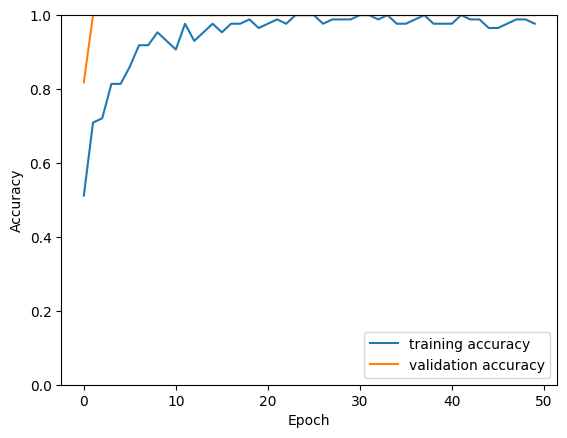

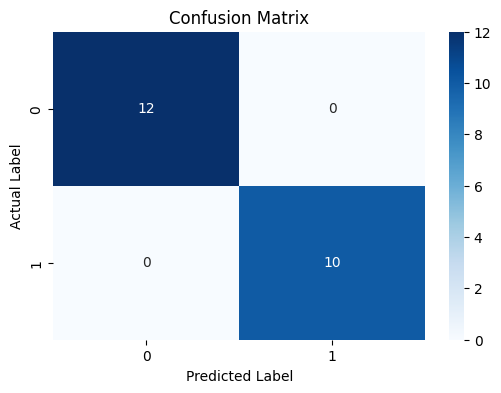

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import DenseNet201  # Changed to DenseNet201
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_densenet201.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
# base_model.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
# history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
#                              validation_data=(X_test, y_test),
#                              epochs=20,
#                              callbacks=[early_stopping, model_checkpoint],
#                              class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Get training accuracy from history after fine-tuning
final_train_acc = history_finetune.history['accuracy'][-1]
print(f'Training accuracy: {final_train_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('densenet201.keras')


In [14]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 90,675,269 (345.90 MB)

 Trainable params: 24,117,761 (92.00 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

 Optimizer params: 48,235,524 (184.00 MB)

In [16]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('densenet201.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im005_1.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted label: Blast


171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step
Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.5078 - loss: 0.9276 - val_accuracy: 0.6818 - val_loss: 0.5870
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5272 - loss: 0.7385 - val_accuracy: 0.6818 - val_loss: 0.5185
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.4884 - loss: 0.6882 - val_accuracy: 0.9091 - val_loss: 0.4562
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6818 - loss: 0.5787 - val_accuracy: 0.9545 - val_loss: 0.4062
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7646 - loss: 0.5055 - val_accuracy: 0.9545 - val_loss: 0.3603
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.7103 - loss: 0.4958 - val_accuracy: 0.9545 - val_loss: 0.3196
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.8060 - loss: 0.4630 - val_accuracy: 1.0000 - val_loss: 0.2775
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7664 - loss: 0.4887 - val_accuracy: 1.0000 - val_loss: 0.2432
Epoch 9/50
3/3 ━━━━

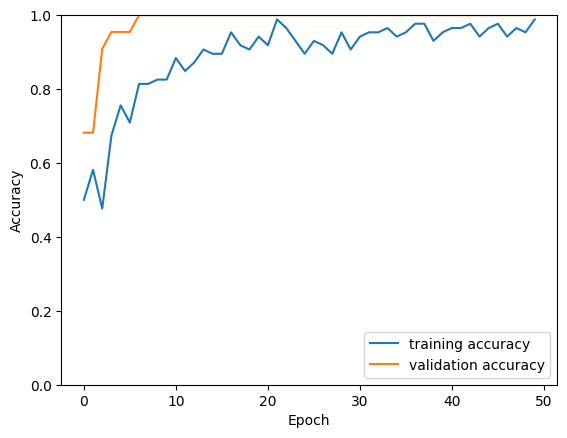

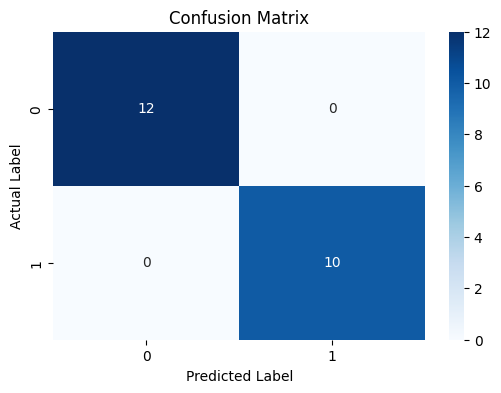

In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import ResNet101V2  # Changed to ResNet101V2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)

# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet101v2.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
# base_model.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
# history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
#                              validation_data=(X_test, y_test),
#                              epochs=20,
#                              callbacks=[early_stopping, model_checkpoint],
#                              class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Get training accuracy from history after fine-tuning
final_train_acc = history_finetune.history['accuracy'][-1]
print(f'Training accuracy: {final_train_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('resnet101v2.keras')


In [18]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 119,796,741 (456.99 MB)

 Trainable params: 25,723,393 (98.13 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

 Optimizer params: 51,446,788 (196.25 MB)

In [19]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('resnet101v2.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'Im005_1.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted label: Blast


VGG16

Epoch 1/50


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.4889 - loss: 0.9053 - val_accuracy: 0.5455 - val_loss: 0.7326
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5032 - loss: 0.8037 - val_accuracy: 0.5455 - val_loss: 0.6792
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.5493 - loss: 0.7525 - val_accuracy: 0.7273 - val_loss: 0.6558
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5875 - loss: 0.6628 - val_accuracy: 0.7273 - val_loss: 0.6421
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.5995 - loss: 0.6356 - val_accuracy: 0.5909 - val_loss: 0.6269
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.6152 - loss: 0.6262 - val_accuracy: 0.6364 - val_loss: 0.5984
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.6986 - loss: 0.5685 - val_accuracy: 0.7727 - val_loss: 0.5621
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.7179 - loss: 0.5980 - val_accuracy: 0.8636 - val_loss: 0.5242
Epoch 9/50
3/3 ━━━━

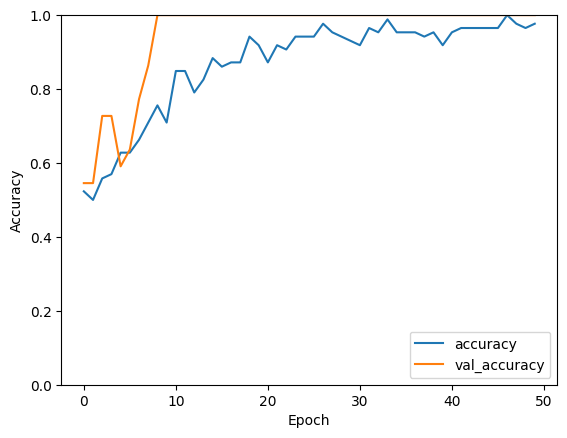

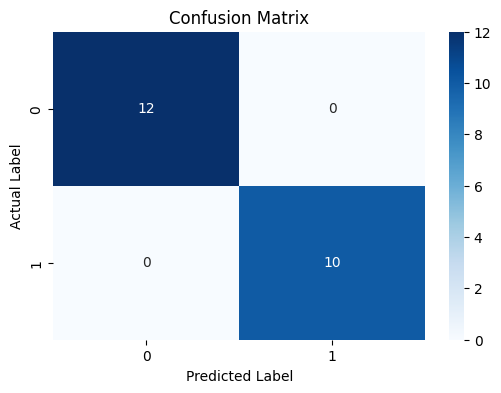

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16  # Changed to VGG19
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix  # Added confusion matrix
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Paths to ALL-IDB1 and ALL-IDB2
all_idb1_blast_dir = 'datasets\\ALL_IDB1\\all_blast'
all_idb1_normal_dir = 'datasets\\ALL_IDB1\\normal'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Sharpening filter
def adaptive_sharpen(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

# Load images
def load_images_from_dir(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (img_width, img_height))
        image = adaptive_sharpen(image)
        image = image / 255.0
        labels.append(label)
        data.append(image)
    return np.array(data), np.array(labels)

all_idb1_blast_data, all_idb1_blast_labels = load_images_from_dir(all_idb1_blast_dir, 1)
all_idb1_normal_data, all_idb1_normal_labels = load_images_from_dir(all_idb1_normal_dir, 0)


# Combine data  
data = np.concatenate([all_idb1_blast_data, all_idb1_normal_data])
labels = np.concatenate([all_idb1_blast_labels, all_idb1_normal_labels])

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define input shape
input_shape = (224, 224, 3)

# Input layer
inputs = Input(shape=input_shape)

# Load pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add Flatten layer
x = Flatten()(base_model.output)

# Add fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

# Output layer (Binary classification: 0 or 1)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights)

# Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                             validation_data=(X_test, y_test),
                             epochs=20,
                             callbacks=[early_stopping, model_checkpoint],
                             class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix using Heatmap
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

model.save('vgg.keras')

In [2]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,511,493 (242.28 MB)

 Trainable params: 21,170,497 (80.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,340,996 (161.52 MB)

In [4]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the model correctly
model = load_model('vgg.keras') 

# Ensure input image is properly preprocessed
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image to the required input size of the VGG16 model
    image = cv2.resize(image, (224, 224))
    
    # Normalize the image (from [0, 255] to [0, 1])
    image = image / 255.0
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    
    return image

# Function to predict the label of an input image
def predict_image(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict using the loaded model
    prediction = model.predict(image)
    
    # Convert prediction to class label (0 or 1)
    predicted_label = int(prediction[0][0] > 0.5)
    
    # Label mapping (0: Normal, 1: Blast)
    labels = {0: 'Normal', 1: 'Blast'}
    
    # return labels[predicted_label]
    return labels[predicted_label]

# Test the prediction function
image_path = 'datasets\\ALL_IDB1\\normal\\Im034_0.jpg'  # Replace with the path to your test image
predicted_label = predict_image(image_path)
print(f'Predicted label: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicted label: Normal
